In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
colnames = ['review_id','sentiment','text']
#data = pd.read_csv('~/reviews.csv.gz', nrows=100, compression='gzip',names = colnames, header = None,
#                   error_bad_lines=False)
data = pd.read_csv('~/reviews_filtered.txt', sep="\t", nrows=10000, names = colnames)
data.head()

,review_id,sentiment,text
0,3872002725,positive,Perfect plan B for our beach wedding that we c...
1,3872002725,positive,Staff were AMAZING - so friendly and accommoda...
2,3872006069,positive,All apartments with a pool view Ten minute wal...
3,3872009990,positive,We had a 2 bedroom suite with a hot tub.
4,3872009990,positive,Very private setting and great atmosphere.


In [3]:
corpus = data['text'].tolist()
corpus[0]
print('total number of reviews: ', len(corpus))

total number of reviews:  10000


In [4]:
%%time
import tensorflow_hub as hub
module = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedder = hub.load(module)
corpus_embeddings = embedder(corpus)

CPU times: user 11.2 s, sys: 9.45 s, total: 20.7 s
Wall time: 8.65 s


In [5]:
print('embedding shape is: ',corpus_embeddings.shape)

embedding shape is:  (10000, 512)


In [180]:
#query = ["Staff were AMAZING - so friendly and accommodating."] #q_id = 1
query = ['We had a 2 bedroom suite with a hot tub.'] #q_id = 3
#query = ['Very private setting and great atmosphere.'] #q_id = 4
q_id = 3
query_vec = embedder(query) #encodes the string in the list
query_vec.shape

TensorShape([1, 512])

In [181]:
correlation = np.transpose(np.inner(query_vec,corpus_embeddings))

In [182]:
df_cor = pd.DataFrame(list(zip(corpus, correlation)), columns = ['text', 'correlation'])
df_cor['review_id'] = data['review_id']
df_cor = df_cor.sort_values(by = 'correlation', ascending = False)
df_cor.head()

,text,correlation,review_id
3,We had a 2 bedroom suite with a hot tub.,[0.9999999],3872009990
6260,The hot tub was perfect after long walks right beside the property.,[0.51062834],3877178741
4040,We really liked the hot tub on the back terrace.,[0.5039953],3875813249
6464,The room has a nice jacuzzi bath and good space in the suite.,[0.49806815],3877300974
8526,Room was very nice and big and the spa bath tub was great🙂,[0.4777955],3877665763


In [183]:
# top 20 most similar text to 'staff were amazing'
# with universal sentence encoder
df_cor.head(10)

,text,correlation,review_id
3,We had a 2 bedroom suite with a hot tub.,[0.9999999],3872009990
6260,The hot tub was perfect after long walks right beside the property.,[0.51062834],3877178741
4040,We really liked the hot tub on the back terrace.,[0.5039953],3875813249
6464,The room has a nice jacuzzi bath and good space in the suite.,[0.49806815],3877300974
8526,Room was very nice and big and the spa bath tub was great🙂,[0.4777955],3877665763
8494,We had a studio room with verandah overlooking the pool.,[0.46912342],3877662530
1920,The pool & hot tub was amazing.,[0.4654414],3874156095
2611,The pool’s jacuzzi was a plus for relaxation.,[0.44877625],3874196780
8450,"We loved the pool, jacuzzi, and the beautiful garden.",[0.42410147],3877659969
7973,Great space to hang out after using the hot tub.,[0.42311567],3877615858


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128578 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(26.49999999999997, 0.5, 'Output Sentence')

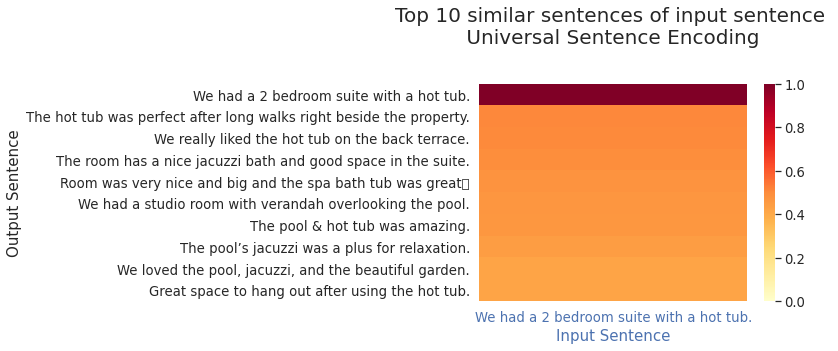

In [184]:
import seaborn as sns

data_plt = df_cor.iloc[np.r_[0:10]]
sns.set(font_scale=1.2)
g = sns.heatmap(
      data_plt['correlation'].tolist(),
      xticklabels=query,
      yticklabels=data_plt['text'].tolist(),
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
g.set_title('Top 10 similar sentences of input sentence \n Universal Sentence Encoding ', fontsize=20, pad=40)
g.set_xlabel('Input Sentence', color = 'b', fontsize = 15)
g.tick_params(axis='x', colors='b')
g.set_ylabel('Output Sentence',fontsize = 15)

In [185]:
%%time
import umap
mapper = umap.UMAP(n_neighbors=100,
                               n_components=384,
                               metric='cosine').fit(corpus_embeddings)

CPU times: user 1h 18min 32s, sys: 16min 48s, total: 1h 35min 21s
Wall time: 1min 1s


In [186]:
mapper.embedding_.shape

(10000, 384)

In [187]:
corpus[q_id]

'We had a 2 bedroom suite with a hot tub.'

In [188]:
query_vec_red =mapper.embedding_[q_id]
query_vec_red.shape

(384,)

In [80]:
def run_euc(query_vec,corpus_vec):
    return np.array([[ np.linalg.norm(i-j) for j in corpus_vec] for i in query_vec])

array([[2.4322693, 3.4264202, 2.1182513, 0.       , 2.1607616]],
      dtype=float32)

In [189]:
#correlation_red = np.transpose(np.inner(query_vec_red,mapper.embedding_))
correlation_red = run_euc([[np.array(query_vec_red)]],np.array(mapper.embedding_))[0]
df_cor_red = pd.DataFrame(list(zip(corpus, correlation_red)), columns = ['text', 'correlation_reduced'])
df_cor_red['review_id'] = data['review_id']
df_cor_red = df_cor_red.sort_values(by = 'correlation_reduced', ascending = True)
df_cor_red.head()

,text,correlation_reduced,review_id
3,We had a 2 bedroom suite with a hot tub.,0.000000,3872009990
4040,We really liked the hot tub on the back terrace.,0.075956,3875813249
1398,The cave including the whirlpool is absolutely amazing and a place to relax.,0.101407,3874115968
3756,So couldn’t use jacuzzi Need a car Other than that.,0.134750,3875704929
6260,The hot tub was perfect after long walks right beside the property.,0.140171,3877178741


In [190]:
df_cor_red.tail(5)

,text,correlation_reduced,review_id
5432,Staff were very friendly and helpful.,4.156804,3875897519
5836,Staff were very friendly and helpful.,4.159103,3877135632
4464,Staff was very friendly and helpful.,4.165325,3875834701
9172,Staff were very friendly and helpful,4.179461,3878405125
326,Staff were very friendly and helpful.,4.196103,3873124247


In [191]:
# top 20 most similar text to 'staff were amazing'
# with umap reduced the dimension from 512 to 384
pd.set_option('display.max_colwidth', -1)
df_cor_red.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,correlation_reduced,review_id
3,We had a 2 bedroom suite with a hot tub.,0.000000,3872009990
4040,We really liked the hot tub on the back terrace.,0.075956,3875813249
1398,The cave including the whirlpool is absolutely amazing and a place to relax.,0.101407,3874115968
3756,So couldn’t use jacuzzi Need a car Other than that.,0.134750,3875704929
6260,The hot tub was perfect after long walks right beside the property.,0.140171,3877178741
4925,"The apartament is very beautiful,clean and very is very complete, the jacuzzi and a point of strength!",0.160461,3875867022
7973,Great space to hang out after using the hot tub.,0.169773,3877615858
738,The jacuzzi is a fantastic idea after Lind walks.,0.201471,3873163217
2611,The pool’s jacuzzi was a plus for relaxation.,0.250958,3874196780
6464,The room has a nice jacuzzi bath and good space in the suite.,0.256595,3877300974


In [192]:
from sklearn import preprocessing

x = df_cor_red['correlation_reduced'].values.reshape( df_cor_red.shape[0],1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_cor_red['correlation_reduced_norm'] = 1- x_scaled

Text(26.49999999999997, 0.5, 'Output Sentence')

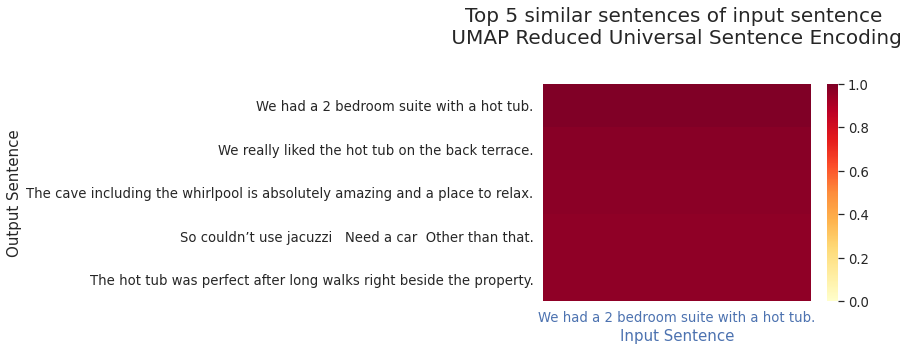

In [193]:
data_plt = df_cor_red.iloc[np.r_[0:5]]
sha = data_plt.shape[0]
sns.set(font_scale=1.2)
g = sns.heatmap(
#      data_plt['correlation_reduced'].values.reshape(sha, 1),
      data_plt['correlation_reduced_norm'].values.reshape(sha, 1),
      xticklabels=query,
      yticklabels=data_plt['text'].tolist(),
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
g.set_title('Top 5 similar sentences of input sentence \n UMAP Reduced Universal Sentence Encoding ', fontsize=20, pad=40)
g.set_xlabel('Input Sentence', color = 'b', fontsize = 15)
g.tick_params(axis='x', colors='b')
g.set_ylabel('Output Sentence',fontsize = 15)